In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# load data
df_all = load_data(file_name="merged_data.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name="data_dict.pkl", file_path=WORK_DATA_DIR)

In [5]:
# select relevant data
df_w = df_all.copy()

## SELECT COLS INCLUDED HERE
drop_cols = data_dict["data_cols"]["fears"] + data_dict["data_cols"]["goog_sent"]
df_w = df_w.drop(drop_cols, axis=1).copy()

# get data on weekly basis
df_w = cut_to_weekly_data(df_w).reset_index(drop=True)

# get lead variable as target
# get lag variable as X
df_w = shift_var_relative_to_df(df_w, shift_var=["sp_close", "sp_close", "sp_close", "sp_close", "sp_close"],
                                new_var_name=["sp_close_lead1", "sp_close_lag1", "sp_close_lag2", "sp_close_lag3", "sp_close_lag4"],
                                no_lags=[-1, 1, 2, 3, 4])

# preserve actual prices
df_w["sp_true_vals"] = df_w["sp_close"]

In [6]:
# get aggregation variables
df_w["sp_agg1"] = df_w.sp_close_lag1 * df_w.sp_close_lag2 * df_w.sp_close_lag3 * df_w.sp_close_lag4

In [7]:
# edit data_dict
# predicted is y col
data_dict.update(predicted="sp_close_lead1")
# actual sp prices
data_dict.update(sp_true_vals="sp_true_vals")
# all sp cols, lags & leads
data_dict.update(sp_cols=["sp_close", "sp_close_lead1", "sp_close_lag1", "sp_close_lag2", "sp_close_lag3", "sp_close_lag4", "sp_agg1"])


relevant_cols=[
    'fears35',
    'fears25',
    'fears30',
    'vixo',
    'naaim_ind',
    'ff_M_RF',
    'ff_SMB',
    'ff_HML',
    'ff_RMW',
    'ff_CMA',
    # 'ff_RF',
    'termspread',
    'pc_ratio',
    'aaii_Bullish',
    'goog_sent'
] 

relevant_cols = [item for item in relevant_cols if item in df_w.columns]

# relevant cols are features + sp_cols + target col, thus all relevant columns
relevant_cols = relevant_cols + data_dict["sp_cols"]

data_dict.update(relevant_cols=relevant_cols)

# predictors are all X cols
data_dict.update(predictor=[item for item in data_dict["relevant_cols"] if item != data_dict["predicted"]])

In [8]:
# log returns
# all cols but ff_factors, as these are returns already
df_w, dist, log = df_log_return(df_w,
                                cols=[item for item in data_dict["relevant_cols"] if item not in data_dict["data_cols"]["ff_factors5"]])

data_dict = update_dict(data_dict,
            update_keys=["dist_translation", "log_return"],
            update_vals=[dist, log])

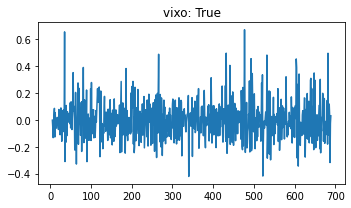

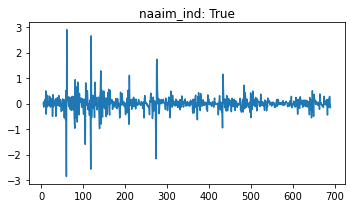

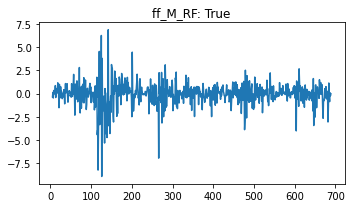

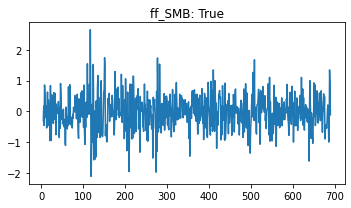

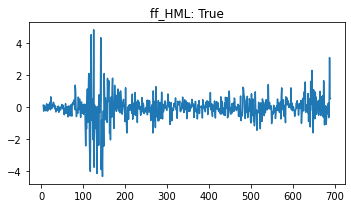

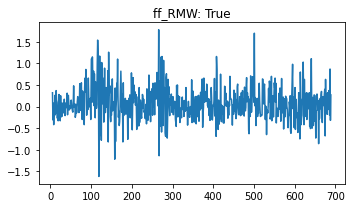

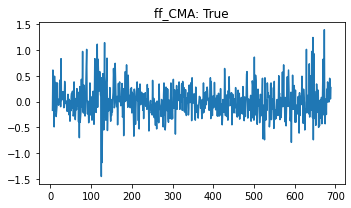

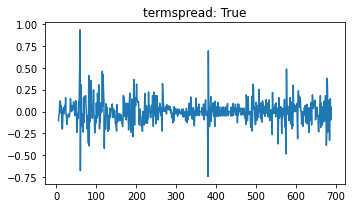

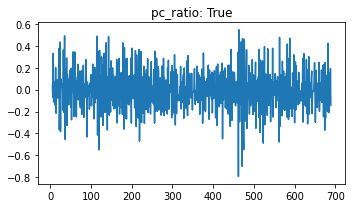

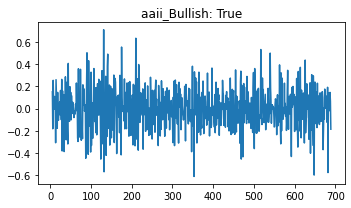

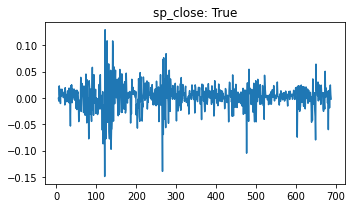

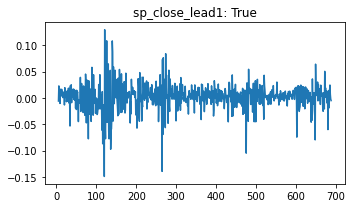

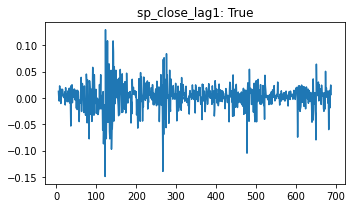

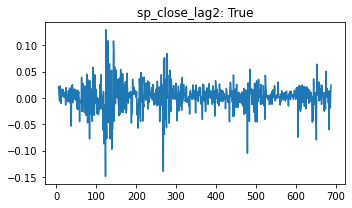

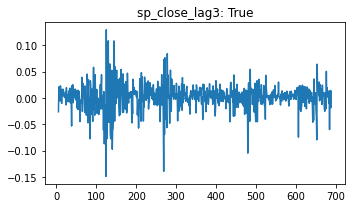

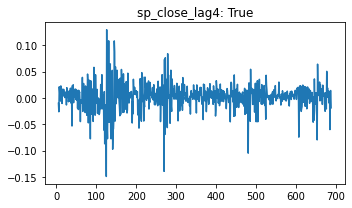

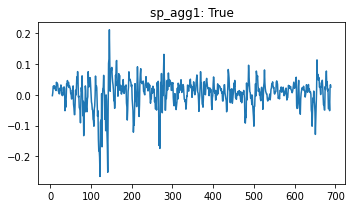

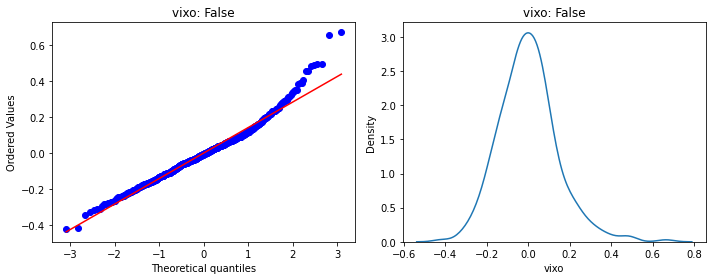

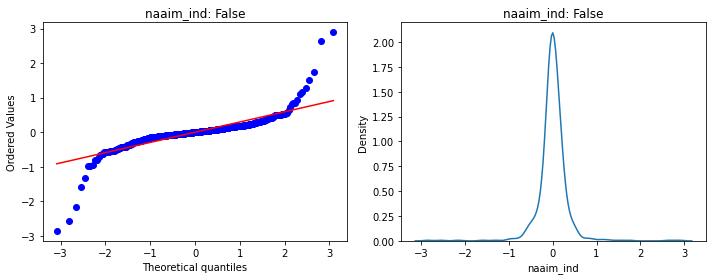

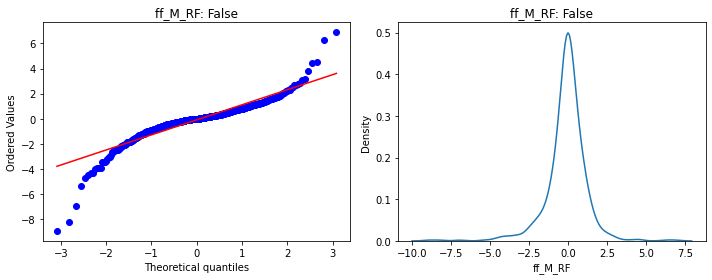

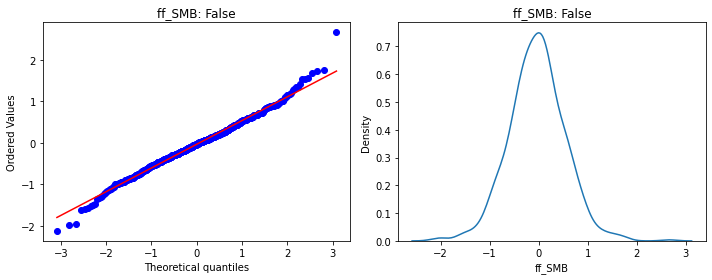

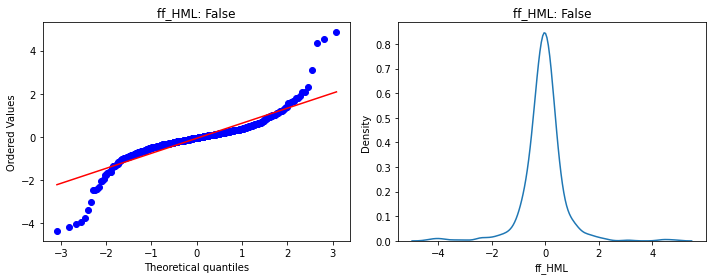

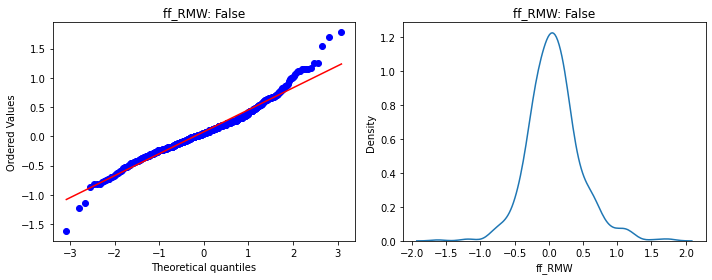

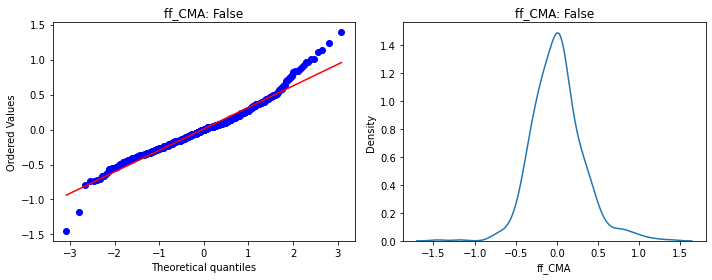

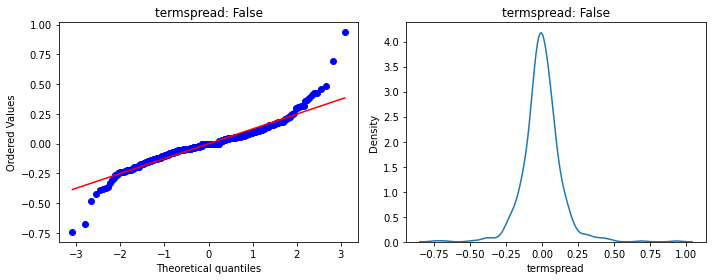

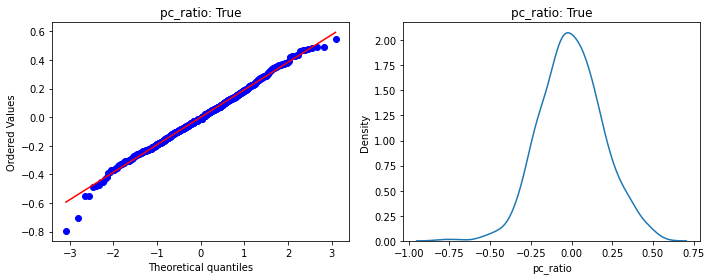

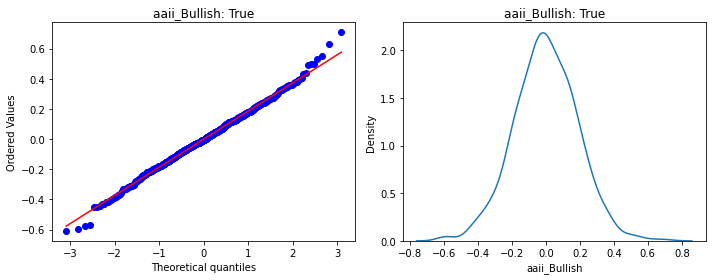

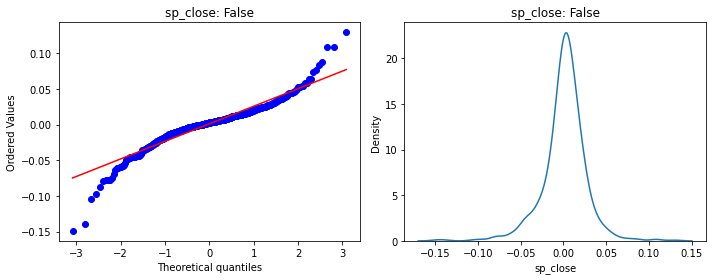

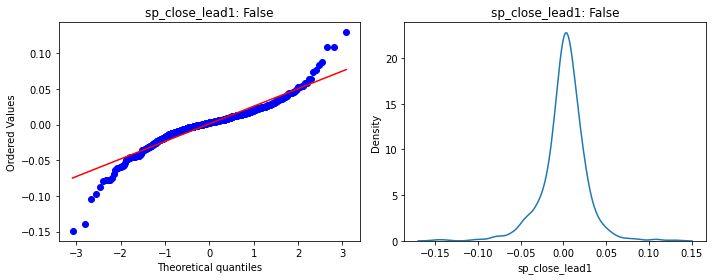

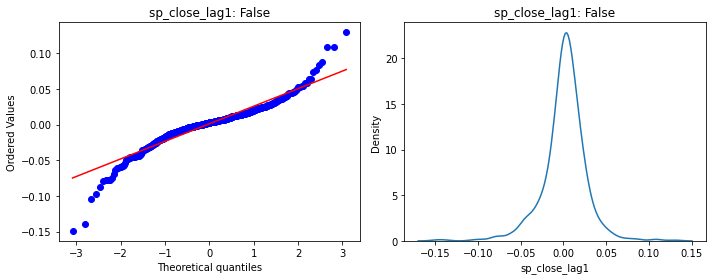

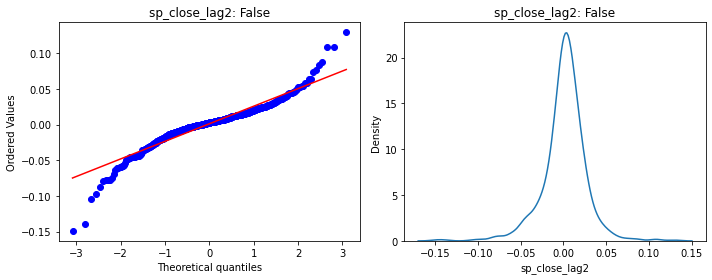

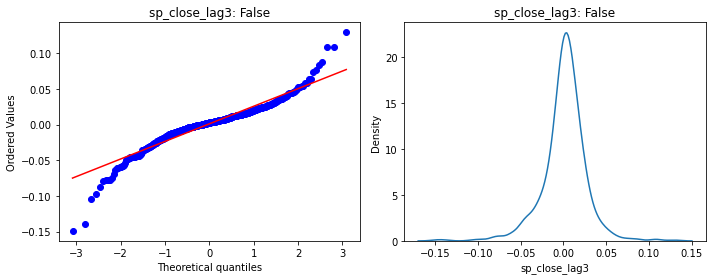

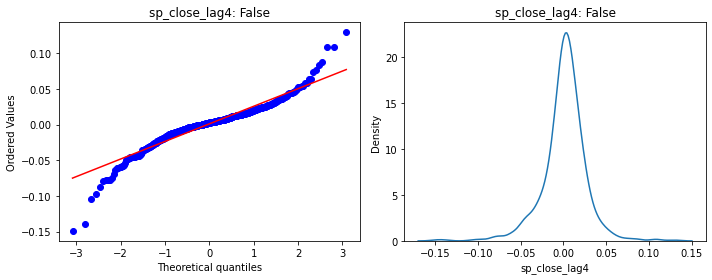

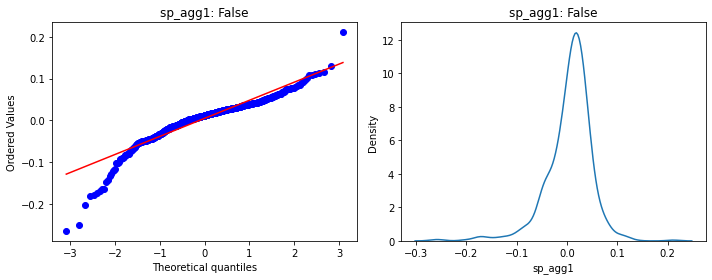

{'vixo': True,
 'naaim_ind': True,
 'ff_M_RF': True,
 'ff_SMB': True,
 'ff_HML': True,
 'ff_RMW': True,
 'ff_CMA': True,
 'termspread': True,
 'pc_ratio': True,
 'aaii_Bullish': True,
 'sp_close': True,
 'sp_close_lead1': True,
 'sp_close_lag1': True,
 'sp_close_lag2': True,
 'sp_close_lag3': True,
 'sp_close_lag4': True,
 'sp_agg1': True}

In [9]:
# test normality & stationarity
stest = StatsTest(plot=True)

stationarity = stest.df_test_stationarity(df_w, data_dict["relevant_cols"])
data_dict.update(stationarity=stationarity)

normality = stest.df_test_normality(df_w, cols=data_dict["relevant_cols"])
data_dict.update(normality=normality)

stationarity

# Saving

In [10]:
df_w.head()

,date,Call,Put,Total,pc_ratio,vixo,vixh,vixl,vix,vxoo,...,naaim_std,naaim_ind,S&P 500,sp_close_lead1,sp_close_lag1,sp_close_lag2,sp_close_lag3,sp_close_lag4,sp_true_vals,sp_agg1
5,2006-08-07,961981.0,841105.0,1803086.0,0.035091,-0.002001,15.53,14.97,15.23,14.59,...,47.48,0.016062,1266.74,-0.005943,0.012414,0.021176,-0.026262,-0.010088,1275.77,-0.002761
6,2006-08-14,1395242.0,1131500.0,2526742.0,-0.071459,-0.057001,14.43,13.41,14.26,13.52,...,56.52,-0.138673,1302.30,0.022848,-0.000697,0.012414,0.021176,-0.026262,1268.21,0.006630
7,2006-08-21,1136785.0,1283293.0,2420078.0,0.332939,-0.132018,12.62,12.21,12.22,11.76,...,45.17,0.077973,1295.09,0.005196,-0.005943,-0.000697,0.012414,0.021176,1297.52,0.026949
8,2006-08-29,965302.0,975093.0,1940395.0,-0.112267,-0.010539,12.83,12.21,12.28,11.23,...,45.17,0.000000,1311.01,0.006854,0.022848,-0.005943,-0.000697,0.012414,1304.28,0.028621
9,2006-09-05,1044476.0,999727.0,2044203.0,-0.050772,0.042288,12.86,12.43,12.63,11.54,...,50.37,0.144985,1298.92,-0.010495,0.005196,0.022848,-0.005943,-0.000697,1313.25,0.021404


In [ ]:
len([item for item in data_dict["data_cols"]["fears"] if item in df_w.columns])

In [12]:
# save dfs with names according to lenght

if len([item for item in data_dict["data_cols"]["fears"] if item in df_w.columns]) == 3:
    save_file(df_w, file_name="df_weekly_281.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_281.pkl", file_path=WORK_DATA_DIR, index=False)
    
elif len([item for item in data_dict["data_cols"]["goog_sent"] if item in df_w.columns]) == 1:
    save_file(df_w, file_name="df_weekly_436.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_436.pkl", file_path=WORK_DATA_DIR, index=False)
    
else:
    save_file(df_w, file_name="df_weekly_685.csv", file_path=WORK_DATA_DIR, index=False)    
    save_file(data_dict, file_name="dict_weekly_685.pkl", file_path=WORK_DATA_DIR, index=False)

Are you sure you want to save model as: f"df_weekly_685.csv"? (y/n)


 y


Are you sure you want to save model as: f"dict_weekly_685.pkl"? (y/n)


 y
